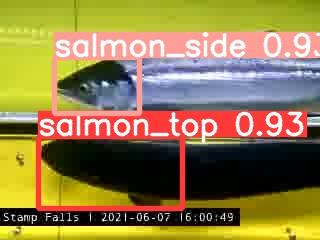

# Fish Detector

We need to be able to properly detect fish if we are going to track and count them. Here we use a [YoloV5](https://github.com/ultralytics/yolov5) object detector trained on a custom-labeled [dataset](https://drive.google.com/drive/folders/12wPQKuvLEl-PPT-IAEVTPlcvmMn9L7q7?usp=sharing) that we created from videos captured using [this python notebook](https://github.com/tjdahlke/fishcam/blob/afa8c4daeaa575b370b490c35ce40e77e8dc2536/Fishcam.ipynb) workflow.

You will first need to download / copy the [dataset](https://drive.google.com/drive/folders/12wPQKuvLEl-PPT-IAEVTPlcvmMn9L7q7?usp=sharing) to your own Google Drive before training the object detector.

The dataset was labeled with two classes. The imagery contains only one species of fish viewed from both side and top viewing cameras. The camera feed from this particular camera is a concatenation of both the top and side viewing camera feeds, so each image frame contains both views in it, as well as a timestamp.

## Initialize

### Get access to data
Once you have the dataset in your own Google Drive account, connect to your Google Drive folder so that Colab has access.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /content/sample_data/

### Get YoloV5 repo

In [ ]:
# Clone YOLOv5 code
%cd $ROOT_PATH
!git clone https://github.com/ultralytics/yolov5.git #https://github.com/rkuo2000/yolov5
%cd $RUN_PATH
%pip install -qr requirements.txt  # install dependencies
import torch
from IPython.display import Image, clear_output  # to display images
clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

### Set environment variables

In [49]:
ROOT_PATH = "/content/drive/MyDrive/fish_detector"
RUN_PATH = ROOT_PATH + "/yolov5"
TRAIN_DATA = ROOT_PATH + "/data/training_data"
VAL_DATA = ROOT_PATH + "/data/val_data"
TEST_DATA = ROOT_PATH + "/data/test_data"

### Setup configuration file

In [50]:
!echo "train: $TRAIN_DATA/images" > $RUN_PATH/data/fish_detector.yaml
!echo "val:   $VAL_DATA/images" >> $RUN_PATH/data/fish_detector.yaml
!echo "test:  $TEST_DATA/images" >> $RUN_PATH/data/fish_detector.yaml

!echo "nc : 2" >> $RUN_PATH/data/fish_detector.yaml
!echo "names: ['salmon_top','salmon_side']" >> $RUN_PATH/data/fish_detector.yaml

!cat $RUN_PATH/data/fish_detector.yaml

train: /content/drive/MyDrive/fishcam/data/training_data/images
val:   /content/drive/MyDrive/fishcam/data/val_data/images
test:   /content/drive/MyDrive/fishcam/data/test_data/images
nc : 2
names: ['salmon_top','salmon_side']


## Training
Weights and Biases is a useful (free) tool for tracking ML training. This step is optional, but recommended.

In [ ]:
# Start weights and biases (optional)
%pip install -q wandb
import wandb
wandb.login()

In [ ]:
%cd $RUN_PATH
!python train.py --img 320 --batch 24 --epochs 100 --data $RUN_PATH/data/fish_detector.yaml --cfg $RUN_PATH/models/yolov5s.yaml

## Inference

In [ ]:
!python detect.py --source $WRKING_DATA/val/images --conf 0.5 --img 320 --weights $RUN_PATH/runs/train/exp/weights/best.pt --save-txt

## Display a sample inference result



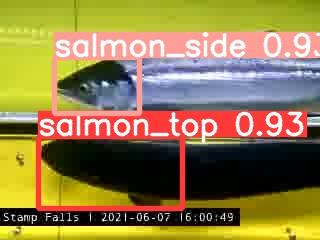

In [53]:
from IPython.display import Image
Image('/content/drive/MyDrive/fishcam/yolov5/runs/detect/exp/thumb-fishvid_0-0021.jpg')

## Testing
Here we get statistics on how well the trained model does on an unseen test dataset, which is made from imagery collected on a different date and time.

In [ ]:
!python val.py --task 'test' --data $RUN_PATH/data/fish_detector.yaml --weights $RUN_PATH/runs/train/exp/weights/best.pt --img 320